In [35]:
import numpy as np 
import cPickle as pkl
from matplotlib import pyplot as plt
import pandas as pd

import theano_time_corex
import linearcorex

import sklearn.covariance as skcov
from sklearn.decomposition import FactorAnalysis, PCA

from generate_data import generate_nglf_from_matrix, generate_nglf_from_model

from sklearn.preprocessing import StandardScaler

import sys

import vis_utils
import metric_utils
import random

from scipy.stats import multivariate_normal

# Load Data

In [79]:
with open('../data/EOD_week.pkl', 'rb') as f:
    df = pd.DataFrame(pkl.load(f))

df = df[df.index >= '2010-01-01']
df = df[df.index <= '2011-01-01']
print("Data.shape = {}".format(df.shape))

# df = df[['AAPL', 'MSFT', 'AMZN', 'INTC', 'BA', 'FDX']]
# df = df.loc[:, list(np.max(np.array(df), axis=0)<1)]

cols = list(df.columns)
random.shuffle(cols)
nv = 128
df = df[cols[:nv]]

print("Data.shape = {}".format(df.shape))

X = []
Y = []

window = 8

for i in range(window, len(df)-window):
    start = i - window
    end = i + window + 1
    part = np.array(df[start : end])
    perm = range(2*window + 1)
    random.shuffle(perm)
    X.append(part[perm[:window], :])
    Y.append(part[perm[window:], :])

print [len(x) for x in X]
print [len(y) for y in Y]

nt = len(X)

Data.shape = (53, 5038)
Data.shape = (53, 128)
[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]


In [80]:
X = X[:10]
Y = Y[:10]

In [81]:
for i in range(len(X)):
    X[i] = np.array(X[i])
    X[i] += np.random.normal(0, 1e-5, size=X[i].shape)
    Y[i] += np.random.normal(0, 1e-5, size=Y[i].shape)
    scaler = StandardScaler()
    X[i] = scaler.fit_transform(X[i])
    Y[i] = scaler.transform(Y[i])

## check ill conditioned

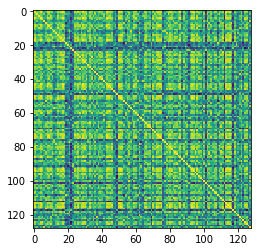

In [82]:
plt.imshow(np.cov(X[0].T))
plt.show()

In [83]:
glasso_covs = []
for x in X:
    glasso_est = skcov.GraphLasso(mode='lars', alpha=110)
    glasso_est.fit(x)
    glasso_covs.append(glasso_est.covariance_)

OverflowError: long int too large to convert to float

# Simple baseline, diagonal covariance

In [84]:
diag_covs = []
for x in X:
    variances = np.var(x, axis=0)
    for i in range(len(variances)):
        if variances[i] < 1e-5:
            print cols[i]
    diag_covs.append(np.diag(variances))

#### This graph shows how well the covariance ESTIMATE of timestep t models the test data at timestep t+1. 

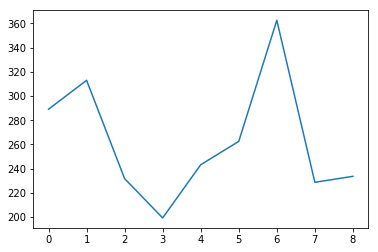

NLL = 262.586897123


In [85]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=diag_covs[t]) for sx in x]) for x,t in zip(Y[1:], range(nt-1))]
plt.plot(nll)
plt.show()
print "NLL = {}".format(np.mean(nll))

#### Negative log-likelihood of cov. estimate on each timestep. We report the sum of negative log-likelihood over timesteps.

In [86]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=diag_covs[t]) for sx in x]) for x,t in zip(Y, range(nt))]
print "NLL = {}".format(np.mean(nll))

NLL = 256.959507283


# Learn independent linear corexes on each timestep

In [104]:
best_nll = 1e18
best_cs = None
best_n_hidden = None
for n_hidden in [4, 8, 16, 24, 32, 50]:
    cs = []
    for x in X:
        c = linearcorex.Corex(n_hidden=n_hidden,
                        max_iter=400,
                        anneal=True)
        c.fit(x)
        cs.append(c)
    corex_covs = [c.get_covariance() for c in cs]
    nll = [-np.mean([multivariate_normal.logpdf(sx, cov=corex_covs[t], allow_singular=False) for sx in x]) for x,t in zip(Y, range(nt))]
    nll = np.mean(nll)
    if nll < best_nll:
        best_nll = nll
        best_cs = cs
        best_n_hidden = n_hidden
    print "nll = {}, n_hidden = {}".format(nll, n_hidden)
            
print "Best n_hidden = {}".format(best_n_hidden)
cs = best_cs

nll = 332.694131898, n_hidden = 4
nll = 311.545237417, n_hidden = 8
nll = 253.441687574, n_hidden = 16
nll = 244.499956091, n_hidden = 24
nll = 242.018509665, n_hidden = 32
nll = 243.835037482, n_hidden = 50
Best n_hidden = 50


In [95]:
corex_covs = [c.get_covariance() for c in cs]

#### This graph shows how well the covariance ESTIMATE of timestep t models the test data at timestep t+1. We would like to see a peak at the middle timestep, but as we don't have many training samples there is no clear peak. We can say that the model overfits a lot at each timestep.

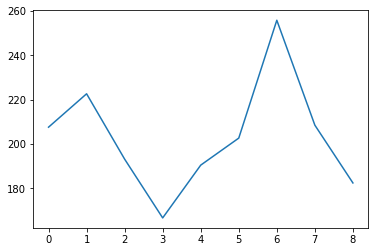

NLL = 203.348359936


In [105]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=corex_covs[t], allow_singular=False) for sx in x]) for x,t in zip(Y[1:], range(nt-1))]
plt.plot(nll)
plt.show()
print "NLL = {}".format(np.mean(nll))

#### Negative log-likelihood of cov. estimate on each timestep. We report the sum of negative log-likelihood over timesteps.

In [106]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=corex_covs[t], allow_singular=False) for sx in x]) for x,t in zip(Y, range(nt))]
print "NLL = {}".format(np.mean(nll))

NLL = 243.835037482


# L1 regularization on the difference of neighbouring covariance estimates

In [107]:
csig = theano_time_corex.TimeCorexSigma(nt=nt,
                                        nv=nv,
                                        n_hidden=32,#best_n_hidden,
                                        max_iter=400,
                                        verbose=False,
                                        anneal=True,
                                        l1=0.1)
csig.fit(X)
print sum(csig.tc)

IndexError: list index out of range

In [ ]:
csig_covs = csig.get_covariance()

#### This graph shows how well the covariance ESTIMATE of timestep t models the test data at timestep t+1. As we regularize the model we have less overfitting and the system is able to find the change at the middle.

In [ ]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=csig_covs[t], allow_singular=False) for sx in x]) for x,t in zip(Y[1:], range(nt-1))]
plt.plot(nll)
plt.show()
print "NLL = {}".format(np.mean(nll))

#### Negative log-likelihood of cov. estimate on each timestep. We report the sum of negative log-likelihood over timesteps.

In [ ]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=csig_covs[t], allow_singular=False) for sx in x]) for x,t in zip(Y, range(nt))]
print "NLL = {}".format(np.mean(nll))

# Other methods of covariance estimation

## Ledoit-Wolf Estimation

In [98]:
lw_covs = []
for x in X:
    lw_est = skcov.LedoitWolf()
    lw_est.fit(x)
    lw_covs.append(lw_est.covariance_)

#### This graph shows how well the covariance ESTIMATE of timestep t models the test data at timestep t+1. 

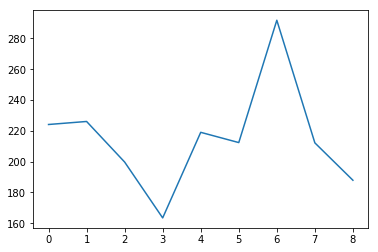

NLL = 215.226424153


In [99]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=lw_covs[t], allow_singular=False) for sx in x]) for x,t in zip(Y[1:], range(nt-1))]
plt.plot(nll)
plt.show()
print "NLL = {}".format(np.mean(nll))

#### Negative log-likelihood of cov. estimate on each timestep. We report the sum of negative log-likelihood over timesteps.

In [100]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=lw_covs[t], allow_singular=False) for sx in x]) for x,t in zip(Y, range(nt))]
print "NLL = {}".format(np.mean(nll))

NLL = 275.579655849


## Oracle Approximating Shrinkage

In [101]:
oas_covs = []
for x in X:
    oas_est = skcov.OAS()
    oas_est.fit(x)
    oas_covs.append(oas_est.covariance_)

#### This graph shows how well the covariance ESTIMATE of timestep t models the test data at timestep t+1. 

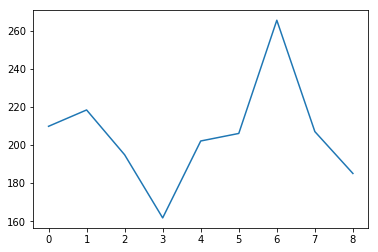

NLL = 205.651038928


In [102]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=oas_covs[t], allow_singular=False) for sx in x]) for x,t in zip(Y[1:], range(nt-1))]
plt.plot(nll)
plt.show()
print "NLL = {}".format(np.mean(nll))

#### Negative log-likelihood of cov. estimate on each timestep. We report the sum of negative log-likelihood over timesteps.

In [103]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=oas_covs[t], allow_singular=False) for sx in x]) for x,t in zip(Y, range(nt))]
print "NLL = {}".format(np.mean(nll))

NLL = 257.405764774


## Graphical LASSO

In [132]:
glasso_covs = []
for x in X:
    glasso_est = skcov.GraphLasso(mode='lars')
    glasso_est.fit(x)
    glasso_covs.append(glasso_est.covariance_)

#### This graph shows how well the covariance ESTIMATE of timestep t models the test data at timestep t+1. 

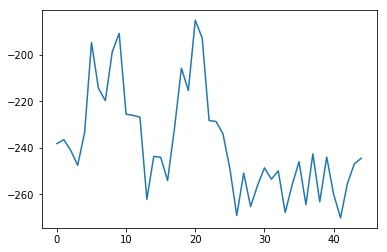

NLL = -238.263243287


In [133]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=glasso_covs[t], allow_singular=False) for sx in x]) for x,t in zip(Y[1:], range(nt-1))]
plt.plot(nll)
plt.show()
print "NLL = {}".format(np.mean(nll))

#### Negative log-likelihood of cov. estimate on each timestep. We report the sum of negative log-likelihood over timesteps.

In [134]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=glasso_covs[t], allow_singular=False) for sx in x]) for x,t in zip(Y, range(nt))]
print "NLL = {}".format(np.mean(nll))

NLL = -216.773266193


# Summary of the results

1) Negative log-likelihood results:

| Model | NLL |  
|:------|----:|  
| independent corexes              | 105237.22 |  
| regularized corex                |  61546.79 |  
| shrinkage estimator (coef = 0.1) | 162136.32 |
| Ledoit-Wolf                      | 52950.41  |
| OAS                              | 49325.46  |
| GLASSO                           | ill cond. |
| Emprical covariance              | ill cond. |

2) Without regularization the system doesn't detect the global change at the middle timestep, but with regularization it finds.